# Tutorial 7 - Transformations of 1D FEP and kinetics

## Introduction

In this notebook, we investigate the impact of the choice of the collective variable on the free energy profile as well as the kinetics. The main conclusion of this notebook will be that the shape of the free energy profile depends on the choice of the CV (as well as for example the difference in free energy between the reactant state minimum and the transition state maximum), however, the derived kinetic rate constant (and hence also the related phenomenological free energy barrier) will not depend on this choice.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from thermolib.thermodynamics.fep import SimpleFreeEnergyProfile, plot_profiles
from thermolib.thermodynamics.histogram import Histogram1D
from thermolib.tools import read_wham_input, blav, decorrelate
from thermolib.thermodynamics.trajectory import ColVarReader
from thermolib.thermodynamics.cv import CoordinationNumber, LinearCombination, FunctionCV
from thermolib.kinetics.rate import RateFactorEquilibrium
from thermolib.units import *

import numpy as np, os

In [3]:
prefix = 'advanced_wham1D_transformations_'

## FEP and rate with original CV

We start be constructing the reference FEP in terms of the original CV, i.e. the CV along which the biasing was performed.

In [4]:
bins = np.arange(-1.7, 1.7, 0.02)
fn_meta = 'data/formic_acid_dimer/wham_input.txt'

In [5]:
colvar_reader = ColVarReader([0], units=['au'])
temp, biasses, trajectories = read_wham_input(
    fn_meta, colvar_reader, 'colvars/COLVAR_%s.dat', 
    bias_potential='Parabola1D', q01_unit='au', kappa1_unit='kjmol',
)

We decorrelate the data using the built-in `decorrelate` routine from the `thermolib.tools` module...

/home/lvduyfhu/miniconda3/envs/thermolib/lib/python3.14/site-packages/thermolib/tools.py:967: OptimizeWarning: Covariance of the parameters could not be estimated
  pars, pcovs = curve_fit(function, upper_envelope_indices, upper_envelope_values, **curve_fit_kwargs)


<Figure size 640x480 with 0 Axes>

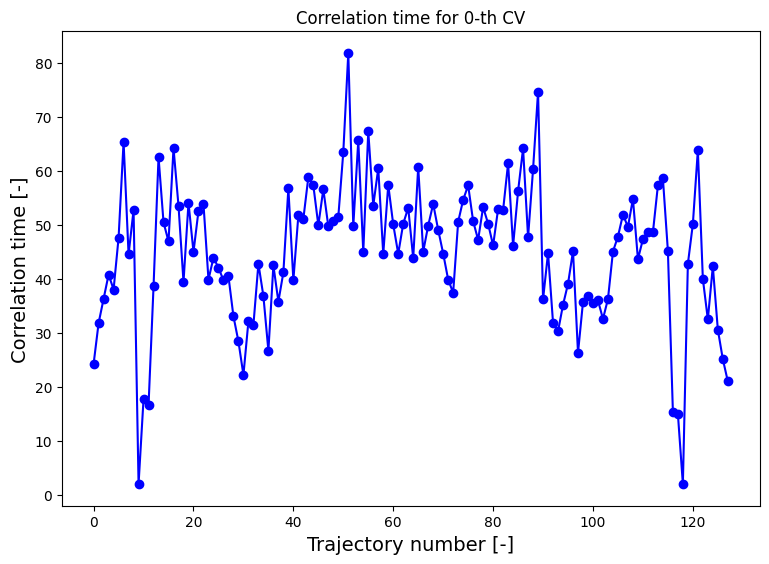

In [6]:
corrtimes = decorrelate(trajectories, plot=True)

...and construct the corresponding FEP

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.013s
  bias poten. : 00h 00m 00.007s
  solve scf   : 00h 00m 00.190s
  error est.  : 00h 00m 00.870s
  TOTAL       : 00h 00m 01.082s
---------------------------------------------------------------------


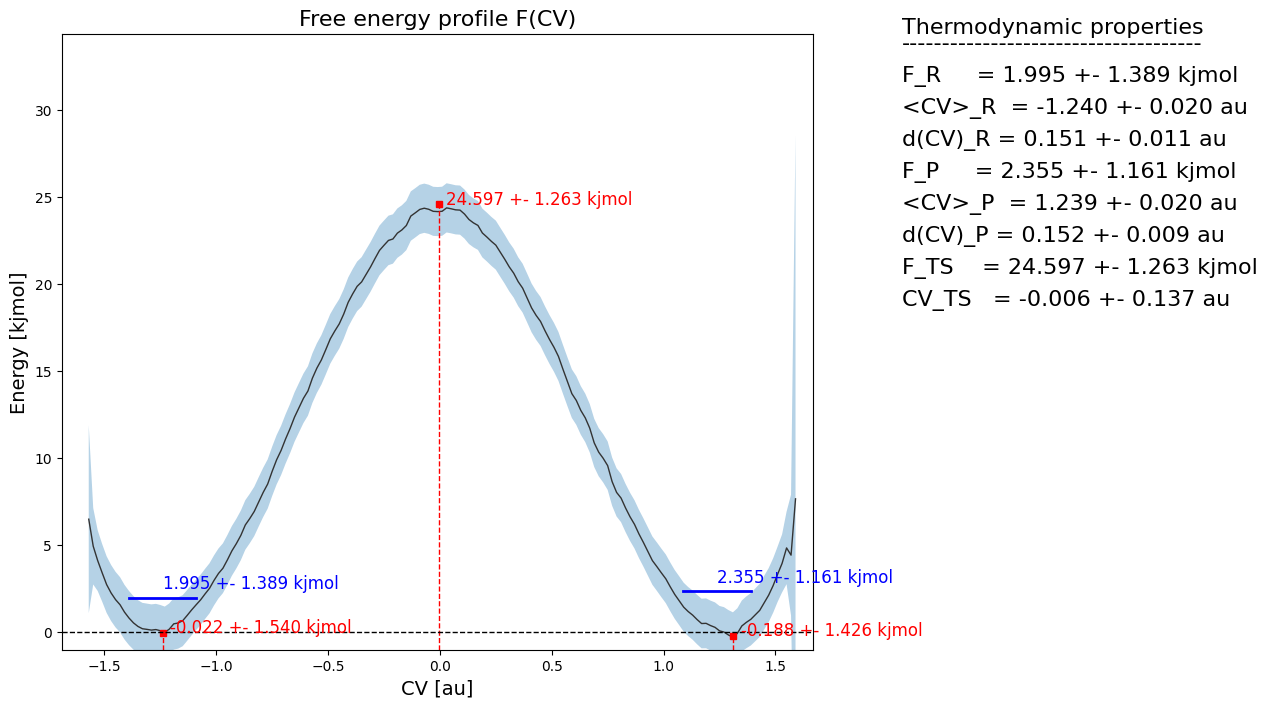

In [7]:
hist = Histogram1D.from_wham(bins, trajectories, biasses, temp, error_estimate='mle_f_cov', corrtimes=corrtimes, Nscf=10000)
fep = SimpleFreeEnergyProfile.from_histogram(hist, temp=temp)
fep.process_states(lims=[-1.55,-0.2,0.2,1.55])
fep.set_ref(ref='r')
fep.plot()

We now also proceed by computing the rate constant according to this CV choice. For this we use all settings as discussed in the [tutorial on basic kinetics](basic_kinetics.html).

In [8]:
#CV definition
C1 = CoordinationNumber([[0,9]], r0=1.4*angstrom)
C2 = CoordinationNumber([[7,9]], r0=1.4*angstrom)
C3 = CoordinationNumber([[2,4]], r0=1.4*angstrom)
C4 = CoordinationNumber([[5,4]], r0=1.4*angstrom)
CV = LinearCombination([C1,C2,C3,C4], [1., -1., -1., 1.])

In [9]:
CV_TS_Delta = 0.05
CV_TS_lims = [fep.ts.get_cv()-CV_TS_Delta, fep.ts.get_cv()+CV_TS_Delta]
rate = RateFactorEquilibrium(CV, CV_TS_lims, temp, CV_unit='au')

In [10]:
fn = '%s/colvars/u64.xyz' %os.path.dirname(fn_meta)
rate.process_trajectory(fn, finish=False, momenta='analytical')
rate.finish()

Rate factor with block averaging:
---------------------------------
  A = 1.746 10^+13 +- 1.125 10^+10 au/s (9073 TS samples, int. autocorr. time = 19.812 timesteps)



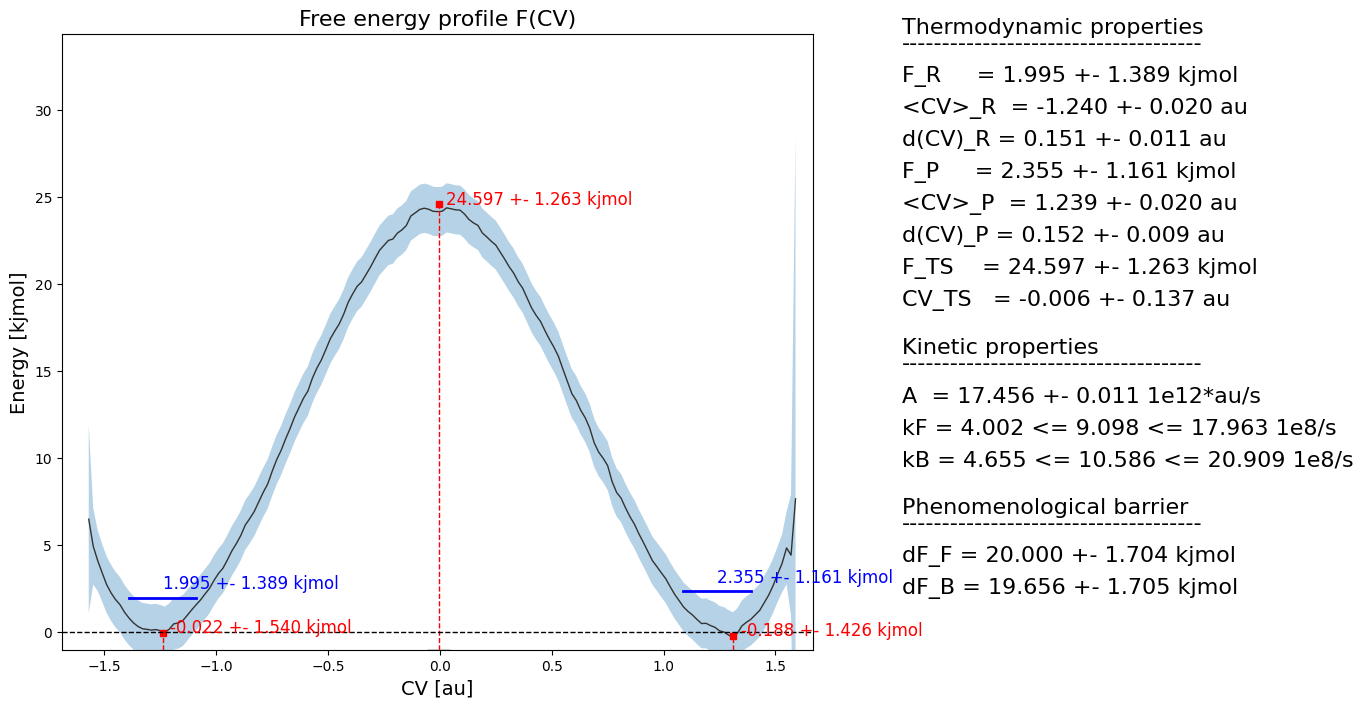

In [11]:
A, A_dist = rate.result_blav()
rate_results = rate.compute_rate(fep)
fep.plot(rate=rate)

## FEP and rate in terms of alternative CV

We are going to transform the FEP from $F(CV)$ towards $F(Q)$ with $Q=\frac{1}{0.9}e^{0.9\cdot CV}$. This can be done using the ``transform`` routine of the BaseFreeEnergyProfile class (as well as it child class SimpleFreeEnergyProfile). For that, we first derive the transformation function as well as its derivative:

In [12]:
def function(cv):
    return np.exp(0.9*cv)

def derivative(cv):
    return 0.9*np.exp(0.9*cv)

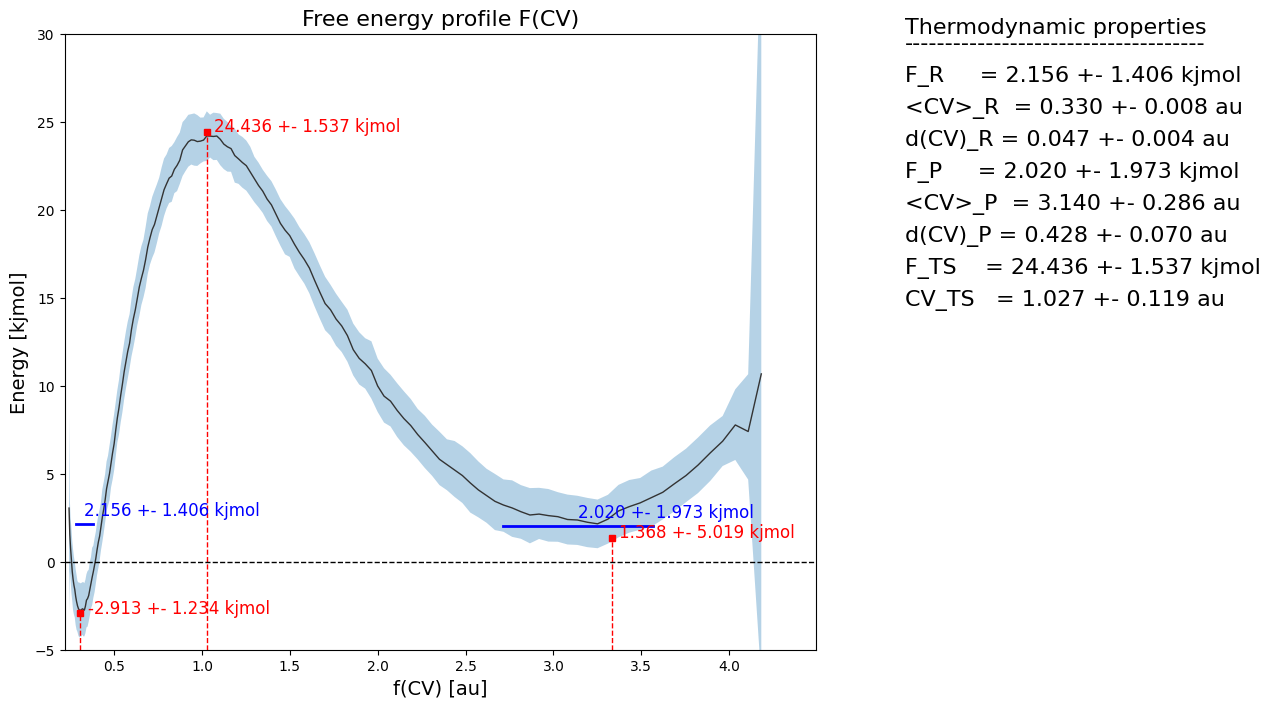

In [13]:
fep2 = fep.transform_function(function, derivative=derivative)
fep2.process_states(lims=[-np.inf,0.9,1.4,4.4])
#fep2.set_ref(ref='r')
fep2.plot(flims=[-5,30])

We clearly see that the free energy profile is not the same anymore as before. We now compute the rate according to the transformed CV and see if that has changed. For this, we use the CollectiveVariable child class ``FunctionCV`` to define a function of another CV:

In [14]:
Q = FunctionCV(CV, function, derivative)

We will need to translate the limits on the TS region in CV space given by

\begin{align}
    CV^{TS}_{lims} = [CV^{TS}-dCV,CV^{TS}+dCV]
\end{align}

to the limits in Q space using the transformation function $Q=f(CV)$ and its derivative $f'(CV)$, which we do as follows:

\begin{align}
    Q^{TS}_{lims} &= [Q^{TS}-dQ,Q^{TS}+dQ] \\
    Q^{TS} &= f(CV^{TS}) \\
    dQ &= f'(CV^{TS})\cdot dCV
\end{align}

In [15]:
Q_TS_Delta = derivative(fep.ts.get_cv())*CV_TS_Delta
Q_TS_lims = [fep2.ts.get_cv()-Q_TS_Delta, fep2.ts.get_cv()+Q_TS_Delta]
print(Q_TS_lims)
rate2 = RateFactorEquilibrium(Q, Q_TS_lims, temp, CV_unit='au')

[np.float64(0.982116771932334), np.float64(1.0716643130863903)]


In [16]:
fn = '%s/colvars/u64.xyz' %os.path.dirname(fn_meta)
rate2.process_trajectory(fn, finish=False, momenta='analytical', verbose=True)
rate2.finish()

Estimating rate factor from trajectory data/formic_acid_dimer/colvars/u64.xyz for TS=[0.982,1.072] au using analytical momentum integration


Rate factor with block averaging:
---------------------------------
  A = 1.594 10^+13 +- 1.973 10^+10 au/s (9079 TS samples, int. autocorr. time = 11.881 timesteps)



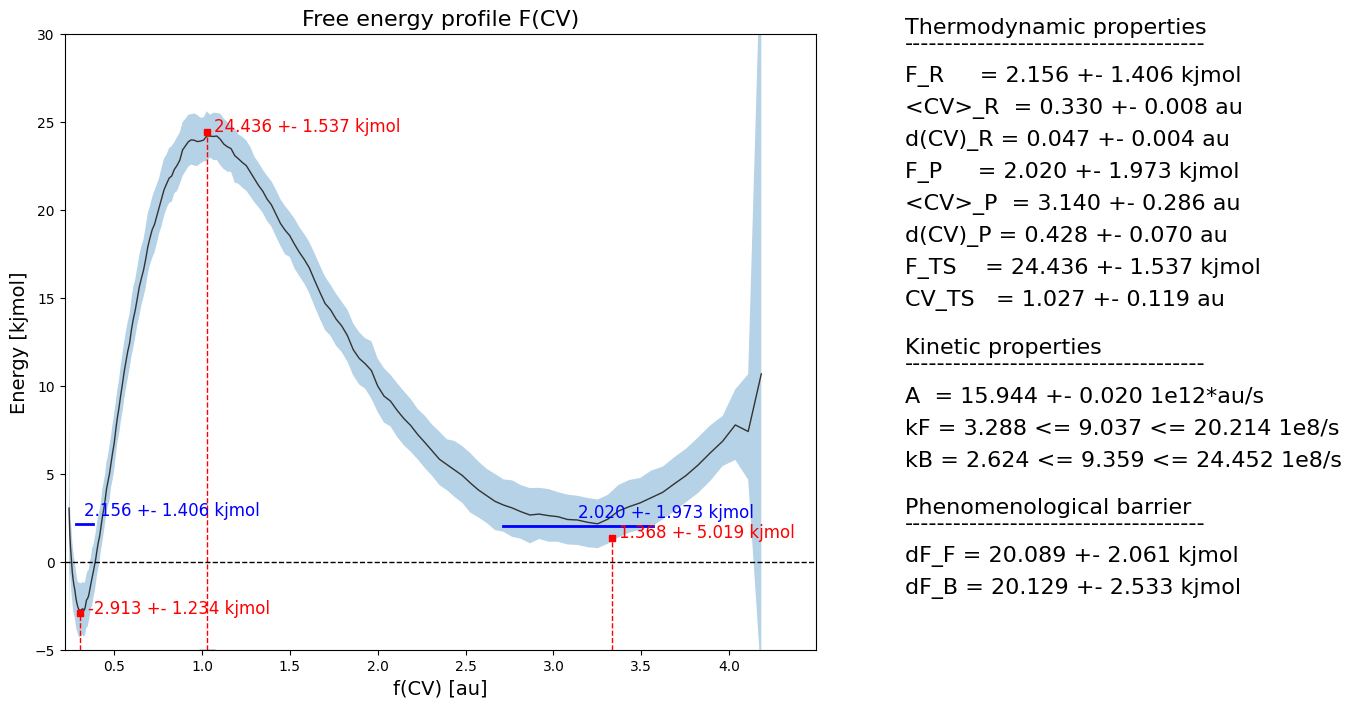

In [17]:
A2, A2_dist = rate2.result_blav()
rate2_results = rate2.compute_rate(fep2)
fep2.plot(rate=rate2,flims=[-5,30])

As we can see, the phenomenological barriers (both forward and backward) remain consistent with those computed with the original CV.